<a href="https://colab.research.google.com/github/Aderonke25/Machine-Learning-Zoomcamp-2025/blob/main/DataTalksModule2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Ridge


In [2]:
url  = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


The goal of this project is to create a regression model for predicting the car fuel efficiency.


In [5]:
# Select only the required columns
selected_columns = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df_selected = df[selected_columns]

In [6]:
print(df_selected.head())

   engine_displacement  horsepower  vehicle_weight  model_year  \
0                  170       159.0     3413.433759        2003   
1                  130        97.0     3149.664934        2007   
2                  170        78.0     3079.038997        2018   
3                  220         NaN     2542.392402        2009   
4                  210       140.0     3460.870990        2009   

   fuel_efficiency_mpg  
0            13.231729  
1            13.688217  
2            14.246341  
3            16.912736  
4            12.488369  


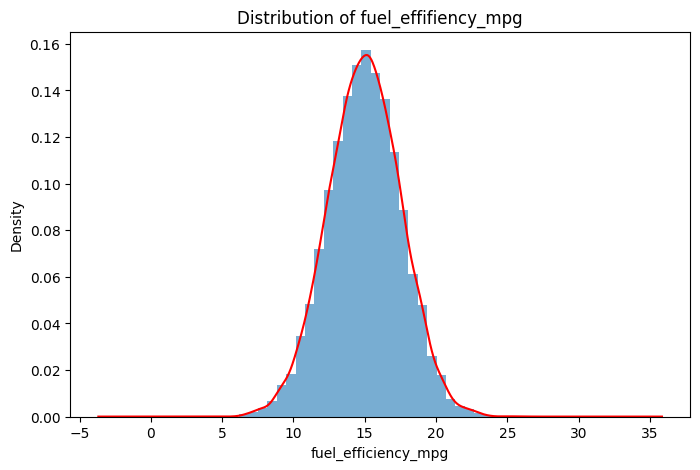

In [7]:
# Histogram + KDE plot
plt.figure(figsize=(8,5))
df['fuel_efficiency_mpg'].plot(kind='hist', bins=30, density=True, alpha=0.6)
df['fuel_efficiency_mpg'].plot(kind='kde', color='red')
plt.title('Distribution of fuel_effifiency_mpg')
plt.xlabel('fuel_efficiency_mpg')
plt.show()

In [8]:
# Skewness value
print("Skewness:", df['fuel_efficiency_mpg'].skew())

Skewness: -0.012062219273507929


A skewness of –0.012 is very close to 0, which means the distribution of fuel_efficiency_mpg is essentially symmetric, with no long tail to the left or right.

#Question 1

In [9]:
print(df_selected.isnull().sum())

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


#Question 2

In [10]:
median_hp = df_selected['horsepower'].median()
print("Median horsepower:", median_hp)


Median horsepower: 149.0


In [11]:
df_selected = df_selected.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
#Split into train (60%) and temp (40%)
train_df, temp_df = train_test_split(
    df_selected,
    test_size=0.4,   # 40% goes into validation + test
    random_state=42
)

#Split the temp set into validation (20%) and test (20%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,   # 50% of 40% = 20% of total
    random_state=42
)

#Check the sizes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (5822, 5)
Validation shape: (1941, 5)
Test shape: (1941, 5)


#Question 3

In [13]:
# --- 1️⃣ Separate features and target ---
X_train = train_df.drop('fuel_efficiency_mpg', axis=1)
y_train = train_df['fuel_efficiency_mpg']

X_val = val_df.drop('fuel_efficiency_mpg', axis=1)
y_val = val_df['fuel_efficiency_mpg']

# --- 2️⃣ Option A: Fill missing 'horsepower' with 0 ---
X_train_zero = X_train.copy()
X_val_zero = X_val.copy()

X_train_zero['horsepower'] = X_train_zero['horsepower'].fillna(0)
X_val_zero['horsepower'] = X_val_zero['horsepower'].fillna(0)

# Train model
model_zero = LinearRegression()
model_zero.fit(X_train_zero, y_train)

# Predict and compute RMSE
val_pred_zero = model_zero.predict(X_val_zero)
rmse_zero = sqrt(mean_squared_error(y_val, val_pred_zero))
rmse_zero = round(rmse_zero, 2)
print("RMSE (fill with 0):", rmse_zero)

# --- 3️⃣ Option B: Fill missing 'horsepower' with mean (computed from training only) ---
hp_mean = X_train['horsepower'].mean()

X_train_mean = X_train.copy()
X_val_mean = X_val.copy()

X_train_mean['horsepower'] = X_train_mean['horsepower'].fillna(hp_mean)
X_val_mean['horsepower'] = X_val_mean['horsepower'].fillna(hp_mean)

# Train model
model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)

# Predict and compute RMSE
val_pred_mean = model_mean.predict(X_val_mean)
rmse_mean = sqrt(mean_squared_error(y_val, val_pred_mean))
rmse_mean = round(rmse_mean, 2)
print("RMSE (fill with mean):", rmse_mean)


RMSE (fill with 0): 0.51
RMSE (fill with mean): 0.46


Since 0.46 < 0.51, the model that fills missing horsepower values with the mean (from the training set) performs better on the validation set. The "with mean" option gives better RMSE.

In [14]:
# Define r values to test
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

# Fill missing horsepower with 0 (as instructed)
X_train_r = X_train.copy()
X_val_r = X_val.copy()
X_train_r['horsepower'] = X_train_r['horsepower'].fillna(0)
X_val_r['horsepower'] = X_val_r['horsepower'].fillna(0)

rmse_scores = {}

for r in r_values:
    model = Ridge(alpha=r)
    model.fit(X_train_r, y_train)

    val_pred = model.predict(X_val_r)
    rmse = sqrt(mean_squared_error(y_val, val_pred))
    rmse_scores[r] = round(rmse, 2)

# Print RMSE for each r
for r, score in rmse_scores.items():
    print(f"r = {r}: RMSE = {score}")


r = 0: RMSE = 0.51
r = 0.01: RMSE = 0.51
r = 0.1: RMSE = 0.51
r = 1: RMSE = 0.51
r = 5: RMSE = 0.51
r = 10: RMSE = 0.51
r = 100: RMSE = 0.51


#Question 5

In [15]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed in seeds:
    # Shuffle & split (60/20/20)
    df_shuffled = df_selected.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df, temp_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)

    # Separate features & target
    X_train = train_df.drop('fuel_efficiency_mpg', axis=1)
    y_train = train_df['fuel_efficiency_mpg']
    X_val = val_df.drop('fuel_efficiency_mpg', axis=1)
    y_val = val_df['fuel_efficiency_mpg']

    # Fill NAs with 0
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)

    # Train linear regression (no regularization)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate on validation
    val_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, val_pred))
    rmse_scores.append(rmse)

# Compute standard deviation of RMSE scores
std_rmse = np.std(rmse_scores)
std_rmse = round(std_rmse, 3)
print("Standard deviation of RMSE scores:", std_rmse)


Standard deviation of RMSE scores: 0.008


#Question 6

In [16]:
#Shuffle & split using seed = 9 (60/20/20)
df_shuffled = df_selected.sample(frac=1, random_state=9).reset_index(drop=True)
train_df, temp_df = train_test_split(df_shuffled, test_size=0.4, random_state=9)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=9)

#Combine train + validation
train_val_df = pd.concat([train_df, val_df])

#Separate features and target
X_train_val = train_val_df.drop('fuel_efficiency_mpg', axis=1)
y_train_val = train_val_df['fuel_efficiency_mpg']

X_test = test_df.drop('fuel_efficiency_mpg', axis=1)
y_test = test_df['fuel_efficiency_mpg']

#Fill missing values with 0
X_train_val = X_train_val.fillna(0)
X_test = X_test.fillna(0)

#Train Ridge model with r = 0.001
model = Ridge(alpha=0.001)
model.fit(X_train_val, y_train_val)

#Evaluate on test set
test_pred = model.predict(X_test)
rmse_test = sqrt(mean_squared_error(y_test, test_pred))
rmse_test = round(rmse_test, 2)
print("Test RMSE (r=0.001):", rmse_test)

Test RMSE (r=0.001): 0.54
